### MNISTデータのダウンロード

In [1]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

In [4]:
url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

In [5]:
dl_file = os.path.join('data', 'mnist.pkl')

In [6]:
def _download(file_name):
    if os.path.exists(dl_file):
        return
    
    print("download start.")
    urllib.request.urlretrieve(url_base + file_name, os.path.join('data', file_name))
    print("download finished!")

In [7]:
def download_mnist():
    for file in key_file.values():
        _download(file)

In [8]:
download_mnist()

In [9]:
def load_label(file_name):
    file_path = os.path.join('data', file_name)
    
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    
    return labels

def load_img(file_name):
    file_path = os.path.join('data', file_name)
    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 784)
    
    return data

In [10]:
# データをファイルに保存
def save(data, file):
    with open(file, 'wb') as f:
        pickle.dump(data, f, -1)

# データをファイルから呼出
def load(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

In [11]:
dataset = {}
dataset['train_img']   = load_img(key_file['train_img'])
dataset['train_label'] = load_label(key_file['train_label'])    
dataset['test_img']    = load_img(key_file['test_img'])
dataset['test_label']  = load_label(key_file['test_label'])

save(dataset, os.path.join('data', 'mnist.pkl'))

In [12]:
# 28×28のイメージデータを表示する
def showImage(image, reshape=True, x=28, y=28):
    if reshape:
        image = image.reshape(x, y)
    plt.imshow(image
               , cmap=matplotlib.cm.binary
               , interpolation='nearest')
    plt.show()

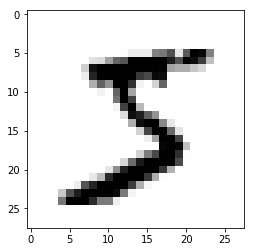

In [13]:
import matplotlib
showImage(dataset['train_img'][0])

# 2項分類器の訓練
* 問題を単純化して1個の数字だけを識別できるようにする
 * 5か5以外の二つのクラスに分類する

In [14]:
# データのロード
data = load(os.path.join('data', 'mnist.pkl'))
x_train = data['train_img']
x_test  = data['test_img']
y_train = data['train_label']
y_test  = data['test_label']

## 確率的勾配降下法
* SGD
* 訓練データを１つ１つ使いながら損失を計算
 * 損失を最小化するような方向へ更新（勾配降下）
 * データは毎周ランダムで並び替えられる

In [15]:
# ここで使うデータを準備する
sgd_data_file = os.path.join('data', 'sgd_ini.pkl')
if os.path.exists(sgd_data_file):
    data = load(sgd_data_file)
else:
    mnist = load(os.path.join('data', 'mnist.pkl'))
    data = {
        'train': {
            'data' : mnist['train_img'],
            'label': mnist['train_label'] == 5
        },
        'test': {
            'data' : mnist['test_img'],
            'label': mnist['test_label'] == 5
        }
    }
    # 次から直接使えるようにファイルに保存
    save(data, sgd_data_file)

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
data

{'train': {'data': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'label': array([ True, False, False, ...,  True, False, False])},
 'test': {'data': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'label': array([False, False, False, ..., False,  True, False])}}

In [18]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(data['train']['data'], data['train']['label'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

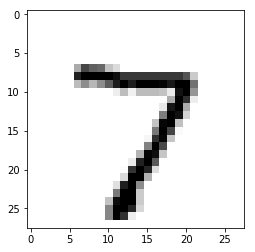

array([False])

In [19]:
sample = data['test']['data'][0]
anster = data['test']['label'][0]
showImage(sample)
sgd_clf.predict([sample])

## 性能指標
### 交差検証を使った正解率の測定
* 交差検証の実装を自力で行う
 * よりきめ細かい交差検証の管理ができる

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [21]:
# StratifiedKFoldは層化抽出のためのインデックスを提供してくれるクラス
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [22]:
for train_index, test_index in skfolds.split(data['train']['data'], data['train']['label']):
    # 分類器の深いコピー
    clone_clf = clone(sgd_clf)
    # 層化抽出
    train_fold       = data['train']['data'][train_index]
    train_fold_label = data['train']['label'][train_index]
    test_fold        = data['train']['data'][test_index]
    test_fold_label  = data['train']['label'][test_index]
    # 学習
    clone_clf.fit(train_fold, train_fold_label)
    # テストデータから推定値を取得する
    predict = clone_clf.predict(test_fold)
    # 正解数を計算
    n_correct = sum(predict == test_fold_label)
    # 計測値を表示
    print('%.2f (%d / %d)' % (n_correct * 100 / len(predict), n_correct, len(predict)))

95.32 (19064 / 20000)
95.12 (19025 / 20000)
96.25 (19250 / 20000)


In [23]:
from sklearn.model_selection import cross_val_score

### K分割交差検証
* 訓練データをK分割
* 検証用のフォールド以外用いて訓練
* 検証用のフォールドで評価

In [24]:
cross_val_score(sgd_clf # 測定器を指定
                , data['train']['data'] # 訓練データ
                , data['train']['label'] # 正解ラベル
                , cv=3 # 分割数
                , scoring='accuracy') # 評価方法（accuracy：正解率）

array([0.9532 , 0.95125, 0.9625 ])

### 考察
* このデータセットでは「５」は10％
* 「５」でないと予測すると90%の正解率を出せるため、あまりイケてる結果ではない
* データの割合に偏りがあるとこんなことになる

### 混同行列
* 「クラスAのインスタンスがクラスBに分類された回数を数える」ということができる

In [25]:
# cross_val_predictはK分割交差検証＋個々のクラスに対する予測結果を取得
from sklearn.model_selection import cross_val_predict

In [26]:
cvp = cross_val_predict(sgd_clf
                       , data['train']['data']
                       , data['train']['label']
                       , cv=3)

In [27]:
# confusion_matrix：混同行列を得るための関数
from sklearn.metrics import confusion_matrix
confusion_matrix(data['train']['label']
                 , cvp)

array([[52992,  1587],
       [ 1074,  4347]], dtype=int64)

### 混合行列の各要素
* 真陰性：True  Negative　⇒　5以外が正しく認識されている
* 偽陽性：False Positive　⇒　5以外が誤って認識されている
* 偽陰性：False Negative　⇒　5が正しく認識されている
* 真陰性：True  Positive　⇒　5が誤って認識されている
### 適合率
* 5だと認識されたもののうち、5が含まれる割合
* TP / ( TP + FP )
### 再現率
* 5が5だと認識される割合
* TP / ( TP + FN )
### F値
* 適合率と再現率の調和平均
* 2 / ( 1 / 適合率 + 1 / 再現率 )

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [29]:
result = {}
# 適合率の計算
result['prediction'] = precision_score(data['train']['label'], cvp)
# 再現率の計算
result['recall']     = recall_score(data['train']['label'], cvp)
# F値の計算
result['F']          = f1_score(data['train']['label'], cvp)

In [30]:
print(result)

{'prediction': 0.7325581395348837, 'recall': 0.8018815716657444, 'F': 0.765653896961691}


### 適合率と再現率のトレードオフ
* クラス判定に用いる閾値をいじることで分類器のメンテナンスが可能

In [31]:
# 予測スコアを取得
score = sgd_clf.decision_function(data['train']['data'])
# 閾値を設定
threshold = 0
# 予測
predict = (score > threshold)

In [32]:
predict

array([False, False, False, ...,  True, False, False])

In [33]:
cvp_scores = cross_val_predict(sgd_clf
                          , data['train']['data']
                          , data['train']['label']
                          , cv=3
                          , method="decision_function")

In [34]:
cvp_scores

array([ 130454.39322866, -292310.89416081, -851504.62149277, ...,
        361078.59565149, -432547.19353153, -420755.44332381])

In [35]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(data['train']['label'], cvp_scores)

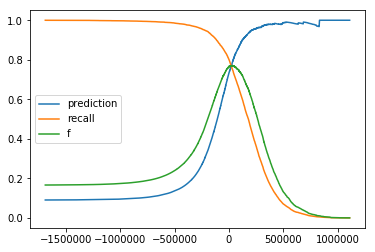

In [36]:
# F値を無理やり計算
f = 2 / (1 / precisions + 1 / recalls)

plt.plot(thresholds, precisions[:-1], label='prediction')
plt.plot(thresholds, recalls[:-1]   , label='recall')
plt.plot(thresholds, f[:-1]         , label='f')
plt.legend(loc='center left')
plt.show()

### ROC曲線
* Reciever Operating Characteristic：受信者動作特性曲線
* 偽陽性率に対する真陽性率をプロットしたもの
 * 偽陽性率：5でないデータが5だと認識された割合
* 性能の比較にはAUC（曲線の下の面積）が使われる
* 完璧な分類器　⇒　AUC=1
* 無作為分類器　⇒　AUC=0.5

In [37]:
from sklearn.metrics import roc_curve

In [38]:
fpr, tpr, thresholds = roc_curve(data['train']['label'], cvp_scores)

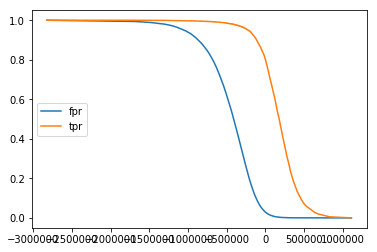

In [39]:
plt.plot(thresholds, fpr, label='fpr')
plt.plot(thresholds, tpr, label='tpr')
plt.legend(loc='center left')
plt.show()

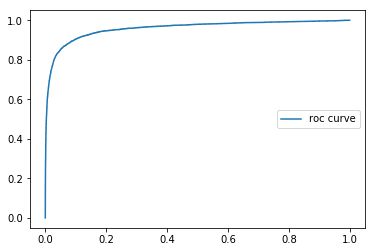

In [40]:
plt.plot(fpr, tpr, label='roc curve')
plt.legend(loc='right')
plt.show()

In [41]:
# AUCを計算する
from sklearn.metrics import roc_auc_score
roc_auc_score(data['train']['label'], cvp_scores)

0.9584692857783504

### ランダムフォレストで訓練＆性能比較
* RandomForestClassifierには「decision_function()」がない
* 代わりに確率を返す「predict_proba()」がある

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
forest_clf = RandomForestClassifier(random_state=42)
forest_prebas = cross_val_predict(forest_clf
                                  , data['train']['data']
                                  , data['train']['label']
                                  , cv=3
                                  , method="predict_proba")

In [44]:
forest_prebas

array([[0.1, 0.9],
       [1. , 0. ],
       [0.9, 0.1],
       ...,
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ]])

In [45]:
# 陽性クラス（５である）確率を取得
scores_forest = forest_prebas[:, 1]

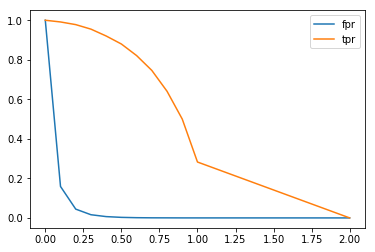

In [46]:
# ROC曲線プロット
fpr_forest, tpr_forest, thresholds_forest = roc_curve(data['train']['label'], scores_forest)
plt.plot(thresholds_forest, fpr_forest, label='fpr')
plt.plot(thresholds_forest, tpr_forest, label='tpr')
plt.legend()
plt.show()

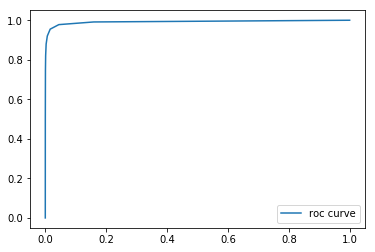

In [47]:
plt.plot(fpr_forest, tpr_forest, label='roc curve')
plt.legend()
plt.show()

In [48]:
roc_auc_score(data['train']['label'], scores_forest)

0.9920527492698306

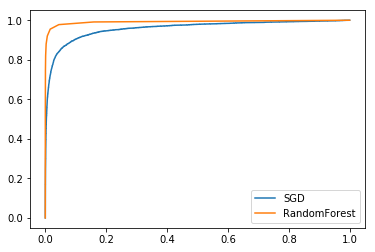

In [49]:
# 比較
plt.plot(fpr, tpr, label='SGD')
plt.plot(fpr_forest, tpr_forest, label='RandomForest')
plt.legend()
plt.show()

# 多クラス分類
* ランダムフォレスト分類器や単純ベイズ分類器は直接多クラスを処理できる
* SVMや線形分類器では無理なので二項分類器を複数組み合わせることで実装
 * OVA法
  * 10個のクラスに分類したければ10個の二項分類器（クラス１検出器、クラス２検出器、・・・）を訓練
  * one versus all
 * OVO法
  * one versus one
  * すべてのクラスのペアに対して二項分類器を訓練する
  * クラスがＮ個ならＮ×（Ｎ－１）／２個の分類器を訓練する

In [50]:
# 計算に時間がかかりそうだから2度目からファイルから結果を取り込むように作り込む
def getSGDMulticlassClassifier(update=False):
    if update or not os.path.exists(os.path.join('data', 'sgd_mc_clf.pkl')):
        mnist = load(os.path.join('data', 'mnist.pkl'))
        data = {
            'train': {
                'image': mnist['train_img'],
                'label': mnist['train_label'],
            },
            'test':  {
                'image': mnist['test_img'],
                'label': mnist['test_label'],
            }
        }
        # 分類器を生成
        clf = SGDClassifier(random_state=42)
        # 分類器を訓練
        clf.fit(data['train']['image'], data['train']['label'])
        # 予測
        predicts = clf.predict(data['train']['image'])
        # 損失計算（交差検証法）
        cvs = cross_val_score(clf, data['train']['image'], data['train']['label'], cv=3, scoring='accuracy')
        # 予測結果取得
        cvp = cross_val_predict(clf, data['train']['image'], data['train']['label'], cv=3)
        # 混同行列取得
        cm = confusion_matrix(data['train']['label'], cvp)
        
        dataset = {
            'clf'     : clf,
            'data'    : data,
            'predicts': predicts,
            'cvs'     : cvs,
            'cvp'     : cvp,
            'cm'      : cm,
        }
        
        save(dataset, os.path.join('data', 'sgd_mc_clf.pkl'))
    else:
        dataset = load(os.path.join('data', 'sgd_mc_clf.pkl'))
    
    return dataset

In [51]:
dataset_sgd_mc = getSGDMulticlassClassifier(update=False)

In [52]:
dataset_sgd_mc

{'clf': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
        n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
        tol=None, verbose=0, warm_start=False),
 'data': {'train': {'image': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   'label': array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)},
  'test': {'image': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   'label': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)}},
 'predicts': array([5, 0,

### OVO法の実装

In [53]:
from sklearn.multiclass import OneVsOneClassifier

def getOVO(update=False):
    if update or not os.path.exists(os.path.join('data', 'ovo.pkl')):
        mnist = load(os.path.join('data', 'mnist.pkl'))
        data = {
            'train': {
                'image': mnist['train_img'],
                'label': mnist['train_label'],
            },
            'test':  {
                'image': mnist['test_img'],
                'label': mnist['test_label'],
            }
        }
        # 分類器生成
        ovo = OneVsOneClassifier(SGDClassifier(random_state=42))
        # 分類器訓練
        ovo.fit(data['train']['image'], data['train']['label'])
        # 予測
        predicts = ovo.predict(data['train']['image'])
        # 損失計算（交差検証法）
        cvs = cross_val_score(ovo, data['train']['image'], data['train']['label'], cv=3, scoring='accuracy')
        
        dataset_ovo = {
            'clf'     : ovo,
            'data'    : data,
            'predicts': predicts,
            'cvs'     : cvs,
        }
        save(dataset_ovo, os.path.join('data', 'ovo.pkl'))
    else:
        dataset_ovo = load(os.path.join('data', 'ovo.pkl'))
    
    return dataset_ovo

In [54]:
dataset_ovo = getOVO(update=False)

In [55]:
dataset_ovo

{'clf': OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
        n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
        tol=None, verbose=0, warm_start=False),
           n_jobs=1),
 'data': {'train': {'image': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   'label': array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)},
  'test': {'image': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   'label': array([7, 2, 1, ..., 

### ランダムフォレストでの多クラス分類

In [56]:
def getRandomForestMulticlassClassifier(update=False):
    if update or not os.path.exists(os.path.join('data', 'random_mc.pkl')):
        mnist = load(os.path.join('data', 'mnist.pkl'))
        data = {
            'train': {
                'image': mnist['train_img'],
                'label': mnist['train_label'],
            },
            'test':  {
                'image': mnist['test_img'],
                'label': mnist['test_label'],
            }
        }
        # 分類器生成
        clf = RandomForestClassifier(random_state=42)
        # 分類器訓練
        clf.fit(data['train']['image'], data['train']['label'])
        # 予測
        predicts = clf.predict(data['train']['image'])
        # 損失計算（交差検証法）
        cvs = cross_val_score(clf, data['train']['image'], data['train']['label'], cv=3, scoring='accuracy')
        # 予測結果取得
        cvp = cross_val_predict(clf, data['train']['image'], data['train']['label'], cv=3)
        # 混同行列取得
        cm = confusion_matrix(data['train']['label'], cvp)
        
        dataset = {
            'clf'     : clf,
            'data'    : data,
            'predicts': predicts,
            'cvs'     : cvs,
            'cm'      : cm,
        }
        save(dataset, os.path.join('data', 'random_mc.pkl'))
    else:
        dataset = load(os.path.join('data', 'random_mc.pkl'))
    
    return dataset

In [57]:
dataset_random_mc = getRandomForestMulticlassClassifier(update=True)

In [58]:
dataset_random_mc

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 'data': {'train': {'image': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   'label': array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)},
  'test': {'image': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# 誤分類の分析

In [59]:
dataset_sgd_mc['clf'].classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

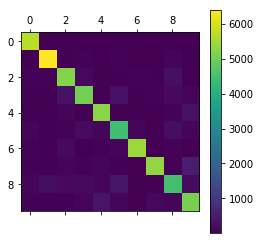

In [60]:
# 混同行列を可視化
plt.matshow(dataset_sgd_mc['cm'])
plt.colorbar()
plt.show()

In [61]:
# ひと工夫
# スケールを合わせる
row_sums = dataset_sgd_mc['cm'].sum(axis=1, keepdims=True)
norm_cm = dataset_sgd_mc['cm'] / row_sums
# 対角要素を0に
np.fill_diagonal(norm_cm, 0)

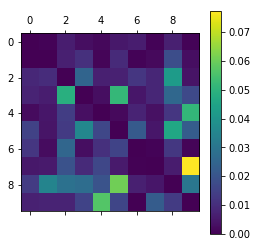

In [62]:
# 混同行列を可視化（2回目）
plt.matshow(norm_cm)
plt.colorbar()
plt.show()

### 考察
* 色が明るい部分ほど誤って判定されやすい組み合わせ
* 次のステップとしては例えば9と7の組み合わせに対して誤分類の修正を行う
 * 使えそうな前処理：scikit-omage, Pillow, OpenCV
* ここで使用したのはSGD（線形モデル）
 * 各ピクセルに重み付けして計算
 * 平行移動や回転に弱い

# 多ラベル分類
* 1つのデータから複数のクラスに分類すること
 * 例）A,Cさんが移っている写真　⇒　A,Cクラスに分類する

In [63]:
from sklearn.neighbors import KNeighborsClassifier

def getKNeighborClassifierSample(update=False):
    if update or not os.path.exists(os.path.join('data', 'kkn_clf_sample.pkl')):
        mnist = load(os.path.join('data', 'mnist.pkl'))
        train_multilabel = np.c_[
            ( mnist['train_label'] >= 7 ),
            ( mnist['train_label'] % 2 == 1 ),
        ]
        test_multilabel = np.c_[
            ( mnist['test_label'] >= 7 ),
            ( mnist['test_label'] % 2 == 1 ),
        ]
        data = {
            'train': {
                'image': mnist['train_img'],
                'label': train_multilabel,
            },
            'test':  {
                'image': mnist['test_img'],
                'label': test_multilabel,
            }
        }
        # 分類器生成
        clf = KNeighborsClassifier()
        # 分類器訓練
        clf.fit(data['train']['image'], data['train']['label'])
        # 予測
        predicts = clf.predict(data['train']['image'])
#         # 損失計算（交差検証法）
#         cvs = cross_val_score(clf, data['train']['image'], data['train']['label'], cv=3, scoring='accuracy')
#         # 予測結果取得
#         cvp = cross_val_predict(clf, data['train']['image'], data['train']['label'], cv=3)
#         # 混同行列取得
#         cm = confusion_matrix(data['train']['label'], cvp)
        
        dataset = {
            'clf'     : clf,
            'data'    : data,
            'predicts': predicts,
#             'cvs'     : cvs,
#             'cm'      : cm,
        }
        save(dataset, os.path.join('data', 'kkn_clf_sample.pkl'))
    else:
        dataset = load(os.path.join('data', 'kkn_clf_sample.pkl'))
    
    return dataset

In [64]:
# dataset_kkn_sample = getKNeighborClassifierSample()
# dataset_kkn_sample

In [65]:
mnist = load(os.path.join('data', 'mnist.pkl'))
train_multilabel = np.c_[
    ( mnist['train_label'] >= 7 ),
    ( mnist['train_label'] % 2 == 1 ),
]
test_multilabel = np.c_[
    ( mnist['test_label'] >= 7 ),
    ( mnist['test_label'] % 2 == 1 ),
]
data = {
    'train': {
        'image': mnist['train_img'],
        'label': train_multilabel,
    },
    'test':  {
        'image': mnist['test_img'],
        'label': test_multilabel,
    }
}

In [66]:
clf = KNeighborsClassifier()

In [68]:
clf.fit(data['train']['image'], data['train']['label'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')